# Import packages

In [1]:
import pandas as pd 
import numpy as np 
import torch
import torch.nn.functional as F
from torch import nn
from torch import optim
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
torch.cuda.is_available()

False

# Import dataset and select x and y data

In [3]:
dataset=pd.read_csv('./data/driver_clean_data.csv')

We will first select all the possible data that we might consider as input data. Then, we will try different networks with different subsets of this big X vector.

In [4]:
Xall = dataset[['Year','RaceResults','GridPos','QualiRes','NumRaces','AvgFinalPos','StdDevFinalPos','MedianFinalPos','AvgStartPos','StdDevStartPos','MedianStartPos']]
y = dataset['Championship Position']

Split in train and test datasets

In [5]:
Xall_train, Xall_test, y_train, y_test = train_test_split(Xall, y, random_state=111,test_size=0.3,shuffle=True)

In [6]:
Xall_train[['AvgFinalPos','StdDevFinalPos']].head()

,AvgFinalPos,StdDevFinalPos
59,8.500000,8.817596
664,7.421053,5.696867
757,12.250000,3.973349
573,14.947368,6.108438
487,15.055556,5.512332


In [7]:
dataset['Championship Position'].max()

46

Since all the input and output values have similar size and there is no more than an order of magnitude of difference between minimum and maximum, there is no need to normalize the values.

In [8]:
yTrain = torch.from_numpy(np.float32(y_train.values))
yTest = torch.from_numpy(np.float32(y_test.values))

# General functions

## Training functions

In [9]:
def trainModelPerEpoch(model,optimModel,lossModel,xtrain,ytrain):
    #Set the model in training mode
    model.train()
    #Set to zero the gradient
    optimModel.zero_grad()
    #Evaluate model on training data
    output = model(xtrain)
    #Compute the loss
    loss_ep = lossModel(output[:,0],ytrain)
    #Backward propagation
    loss_ep.backward()
    #Update the weights of the model
    optimModel.step()
    return loss_ep.item()

In [10]:
def trainModel(start_ep,num_ep,model,optimModel,lossModel,xtrain,ytrain):
    loss_train_arr = []
    for epoch in range(start_ep,num_ep+1):
        #Execute the training function
        loss_epoch = trainModelPerEpoch(model,optimModel,lossModel,xtrain,ytrain)
        loss_train_arr.append(loss_epoch) 
        #Print update.
        print('Epoch {:.0f} out of {:.0f}, Training Loss: {:.3e}'.format(epoch+1,num_ep,loss_epoch))
        
    return np.array(loss_train_arr)

## Validation functions

In [11]:
def validateModel(model,lossModel,xval,yval):
    output = model(xval)
    #Compute the loss
    loss_val = lossModel(output[:,0],yval)
    #Backward propagation
    print('Validation Loss: {:.3e}'.format(loss_val.item()))
    
    return loss_val.item()

## Training and Validation function

In [12]:
def trainValModel(start_ep,num_ep,model,optimModel,lossModel,xtrain,ytrain,xval,yval):
    loss_train_val_arr = []
    for epoch in range(start_ep,num_ep+1):
        #Execute the training function
        loss_train_epoch = trainModelPerEpoch(model,optimModel,lossModel,xtrain,ytrain)
        loss_val_epoch = validateModel(model,lossModel,xval,yval)
        loss_train_val_arr.append([epoch+1,loss_train_epoch,loss_val_epoch]) 
        #Print update.
        print('####Epoch {:.0f} out of {:.0f}###\n\t---Training Loss: {:.3e},\n\t---Validation Loss: {:.3e}'.format(epoch+1,num_ep,loss_train_epoch,loss_val_epoch))
        
    return np.array(loss_train_val_arr)

## Loss functions

In [13]:
loss_MLF1 = nn.MSELoss()

# Models

Now, I will construct different models with different inputs to compare their predictive power.
They will all use dense layers. I will also test different hyperparameter configurations.
The output  will not be hardcoded, i.e. the last layer will give a number between 1 and 46, which is the maximum Championship position found in the dataset.

## Model 1: Final position average and standard deviation as input

## Define inpute data for this model

In [14]:
xmod1_train=torch.from_numpy(np.float32(Xall_train[['AvgFinalPos','StdDevFinalPos']].values))
xmod1_test=torch.from_numpy(np.float32(Xall_test[['AvgFinalPos','StdDevFinalPos']].values))

### Define model architecture

In Pytorch, this is done by defining a new class

In [15]:
class MLF1mod1(nn.Module):
    def __init__(self):
        super().__init__()
        self.lay1 = nn.Linear(2,10)
        self.lay2 = nn.Linear(10,20)
        self.lay3 = nn.Linear(20,10)
        self.lay4  = nn.Linear(10,1)
        
    def forward(self, x):
        x = F.relu(self.lay1(x))
        x = F.relu(self.lay2(x))
        x = F.relu(self.lay3(x))
        x = self.lay4(x)
        return x

## Compile model

In [16]:
model1 = MLF1mod1()

In [17]:
optimMod1 = optim.Adam(model1.parameters(), lr=0.001)

In [18]:
res=model1(xmod1_train)

## Train model

In [19]:
loss_trval_mod1_arr=trainValModel(0,350,model1,optimMod1,loss_MLF1,xmod1_train,yTrain,xmod1_test,yTest)

Validation Loss: 3.022e+02
####Epoch 1 out of 350###
	---Training Loss: 2.789e+02,
	---Validation Loss: 3.022e+02
Validation Loss: 3.007e+02
####Epoch 2 out of 350###
	---Training Loss: 2.775e+02,
	---Validation Loss: 3.007e+02
Validation Loss: 2.993e+02
####Epoch 3 out of 350###
	---Training Loss: 2.761e+02,
	---Validation Loss: 2.993e+02
Validation Loss: 2.979e+02
####Epoch 4 out of 350###
	---Training Loss: 2.747e+02,
	---Validation Loss: 2.979e+02
Validation Loss: 2.965e+02
####Epoch 5 out of 350###
	---Training Loss: 2.734e+02,
	---Validation Loss: 2.965e+02
Validation Loss: 2.952e+02
####Epoch 6 out of 350###
	---Training Loss: 2.721e+02,
	---Validation Loss: 2.952e+02
Validation Loss: 2.938e+02
####Epoch 7 out of 350###
	---Training Loss: 2.709e+02,
	---Validation Loss: 2.938e+02
Validation Loss: 2.926e+02
####Epoch 8 out of 350###
	---Training Loss: 2.696e+02,
	---Validation Loss: 2.926e+02
Validation Loss: 2.913e+02
####Epoch 9 out of 350###
	---Training Loss: 2.684e+02,
	---V

Validation Loss: 3.874e+01
####Epoch 141 out of 350###
	---Training Loss: 3.740e+01,
	---Validation Loss: 3.874e+01
Validation Loss: 3.850e+01
####Epoch 142 out of 350###
	---Training Loss: 3.721e+01,
	---Validation Loss: 3.850e+01
Validation Loss: 3.827e+01
####Epoch 143 out of 350###
	---Training Loss: 3.701e+01,
	---Validation Loss: 3.827e+01
Validation Loss: 3.804e+01
####Epoch 144 out of 350###
	---Training Loss: 3.682e+01,
	---Validation Loss: 3.804e+01
Validation Loss: 3.781e+01
####Epoch 145 out of 350###
	---Training Loss: 3.663e+01,
	---Validation Loss: 3.781e+01
Validation Loss: 3.758e+01
####Epoch 146 out of 350###
	---Training Loss: 3.643e+01,
	---Validation Loss: 3.758e+01
Validation Loss: 3.736e+01
####Epoch 147 out of 350###
	---Training Loss: 3.624e+01,
	---Validation Loss: 3.736e+01
Validation Loss: 3.714e+01
####Epoch 148 out of 350###
	---Training Loss: 3.604e+01,
	---Validation Loss: 3.714e+01
Validation Loss: 3.692e+01
####Epoch 149 out of 350###
	---Training Loss

Validation Loss: 1.699e+01
####Epoch 291 out of 350###
	---Training Loss: 1.492e+01,
	---Validation Loss: 1.699e+01
Validation Loss: 1.697e+01
####Epoch 292 out of 350###
	---Training Loss: 1.487e+01,
	---Validation Loss: 1.697e+01
Validation Loss: 1.695e+01
####Epoch 293 out of 350###
	---Training Loss: 1.483e+01,
	---Validation Loss: 1.695e+01
Validation Loss: 1.693e+01
####Epoch 294 out of 350###
	---Training Loss: 1.479e+01,
	---Validation Loss: 1.693e+01
Validation Loss: 1.692e+01
####Epoch 295 out of 350###
	---Training Loss: 1.475e+01,
	---Validation Loss: 1.692e+01
Validation Loss: 1.691e+01
####Epoch 296 out of 350###
	---Training Loss: 1.472e+01,
	---Validation Loss: 1.691e+01
Validation Loss: 1.690e+01
####Epoch 297 out of 350###
	---Training Loss: 1.468e+01,
	---Validation Loss: 1.690e+01
Validation Loss: 1.690e+01
####Epoch 298 out of 350###
	---Training Loss: 1.465e+01,
	---Validation Loss: 1.690e+01
Validation Loss: 1.690e+01
####Epoch 299 out of 350###
	---Training Loss

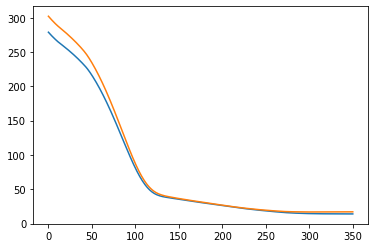

In [20]:
plt.plot(loss_trval_mod1_arr[:,1])
plt.plot(loss_trval_mod1_arr[:,2])
plt.show()

## Model 2: Final position average, standard deviation and median as input

## Selecte input data for this model

In [21]:
xmod2_train=torch.from_numpy(np.float32(Xall_train[['AvgFinalPos','StdDevFinalPos','MedianFinalPos']].values))
xmod2_test=torch.from_numpy(np.float32(Xall_test[['AvgFinalPos','StdDevFinalPos','MedianFinalPos']].values))

### Define model architecture

In [22]:
class MLF1mod2(nn.Module):
    def __init__(self):
        super().__init__()
        self.lay1 = nn.Linear(3,10)
        self.lay2 = nn.Linear(10,20)
        self.lay3 = nn.Linear(20,10)
        self.lay4  = nn.Linear(10,1)
        
    def forward(self, x):
        x = F.relu(self.lay1(x))
        x = F.relu(self.lay2(x))
        x = F.relu(self.lay3(x))
        x = self.lay4(x)
        return x

### Compile model and show summary

In [23]:
model2 = MLF1mod2()

In [24]:
optimMod2 = optim.Adam(model2.parameters(), lr=0.001)

### Train and evaluate model

In [25]:
loss_trval_mod2_arr=trainValModel(0,200,model2,optimMod2,loss_MLF1,xmod2_train,yTrain,xmod2_test,yTest)

Validation Loss: 3.031e+02
####Epoch 1 out of 200###
	---Training Loss: 2.785e+02,
	---Validation Loss: 3.031e+02
Validation Loss: 3.028e+02
####Epoch 2 out of 200###
	---Training Loss: 2.782e+02,
	---Validation Loss: 3.028e+02
Validation Loss: 3.025e+02
####Epoch 3 out of 200###
	---Training Loss: 2.779e+02,
	---Validation Loss: 3.025e+02
Validation Loss: 3.021e+02
####Epoch 4 out of 200###
	---Training Loss: 2.775e+02,
	---Validation Loss: 3.021e+02
Validation Loss: 3.017e+02
####Epoch 5 out of 200###
	---Training Loss: 2.772e+02,
	---Validation Loss: 3.017e+02
Validation Loss: 3.013e+02
####Epoch 6 out of 200###
	---Training Loss: 2.769e+02,
	---Validation Loss: 3.013e+02
Validation Loss: 3.009e+02
####Epoch 7 out of 200###
	---Training Loss: 2.765e+02,
	---Validation Loss: 3.009e+02
Validation Loss: 3.005e+02
####Epoch 8 out of 200###
	---Training Loss: 2.761e+02,
	---Validation Loss: 3.005e+02
Validation Loss: 3.000e+02
####Epoch 9 out of 200###
	---Training Loss: 2.757e+02,
	---V

Validation Loss: 9.066e+01
####Epoch 118 out of 200###
	---Training Loss: 8.585e+01,
	---Validation Loss: 9.066e+01
Validation Loss: 8.786e+01
####Epoch 119 out of 200###
	---Training Loss: 8.324e+01,
	---Validation Loss: 8.786e+01
Validation Loss: 8.511e+01
####Epoch 120 out of 200###
	---Training Loss: 8.068e+01,
	---Validation Loss: 8.511e+01
Validation Loss: 8.242e+01
####Epoch 121 out of 200###
	---Training Loss: 7.817e+01,
	---Validation Loss: 8.242e+01
Validation Loss: 7.980e+01
####Epoch 122 out of 200###
	---Training Loss: 7.571e+01,
	---Validation Loss: 7.980e+01
Validation Loss: 7.724e+01
####Epoch 123 out of 200###
	---Training Loss: 7.330e+01,
	---Validation Loss: 7.724e+01
Validation Loss: 7.476e+01
####Epoch 124 out of 200###
	---Training Loss: 7.096e+01,
	---Validation Loss: 7.476e+01
Validation Loss: 7.235e+01
####Epoch 125 out of 200###
	---Training Loss: 6.868e+01,
	---Validation Loss: 7.235e+01
Validation Loss: 7.001e+01
####Epoch 126 out of 200###
	---Training Loss

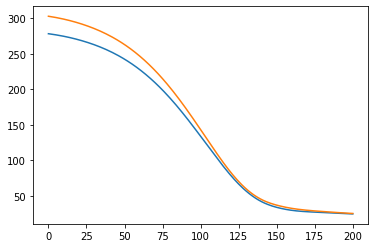

In [26]:
plt.plot(loss_trval_mod2_arr[:,1])
plt.plot(loss_trval_mod2_arr[:,2])
plt.show()

## Model 3: Mean and standard deviation of grid and final race position

## Selecte input data for this model

In [27]:
xmod3_train=torch.from_numpy(np.float32(Xall_train[['AvgFinalPos','StdDevFinalPos','AvgStartPos','StdDevStartPos']].values))
xmod3_test=torch.from_numpy(np.float32(Xall_test[['AvgFinalPos','StdDevFinalPos','AvgStartPos','StdDevStartPos']].values))

### Define model architecture

In [28]:
class MLF1mod3(nn.Module):
    def __init__(self):
        super().__init__()
        self.lay1 = nn.Linear(4,10)
        self.lay2 = nn.Linear(10,20)
        self.lay3 = nn.Linear(20,10)
        self.lay4  = nn.Linear(10,1)
        
    def forward(self, x):
        x = F.relu(self.lay1(x))
        x = F.relu(self.lay2(x))
        x = F.relu(self.lay3(x))
        x = self.lay4(x)
        return x

### Compile model and show summary

In [29]:
model3 = MLF1mod3()

In [30]:
optimMod3 = optim.Adam(model3.parameters(), lr=0.001)

### Train and evaluate model

In [31]:
loss_trval_mod3_arr=trainValModel(0,200,model3,optimMod3,loss_MLF1,xmod3_train,yTrain,xmod3_test,yTest)

Validation Loss: 3.138e+02
####Epoch 1 out of 200###
	---Training Loss: 2.907e+02,
	---Validation Loss: 3.138e+02
Validation Loss: 3.111e+02
####Epoch 2 out of 200###
	---Training Loss: 2.880e+02,
	---Validation Loss: 3.111e+02
Validation Loss: 3.084e+02
####Epoch 3 out of 200###
	---Training Loss: 2.854e+02,
	---Validation Loss: 3.084e+02
Validation Loss: 3.058e+02
####Epoch 4 out of 200###
	---Training Loss: 2.829e+02,
	---Validation Loss: 3.058e+02
Validation Loss: 3.032e+02
####Epoch 5 out of 200###
	---Training Loss: 2.804e+02,
	---Validation Loss: 3.032e+02
Validation Loss: 3.006e+02
####Epoch 6 out of 200###
	---Training Loss: 2.780e+02,
	---Validation Loss: 3.006e+02
Validation Loss: 2.980e+02
####Epoch 7 out of 200###
	---Training Loss: 2.756e+02,
	---Validation Loss: 2.980e+02
Validation Loss: 2.954e+02
####Epoch 8 out of 200###
	---Training Loss: 2.732e+02,
	---Validation Loss: 2.954e+02
Validation Loss: 2.928e+02
####Epoch 9 out of 200###
	---Training Loss: 2.708e+02,
	---V

Validation Loss: 3.477e+01
####Epoch 119 out of 200###
	---Training Loss: 2.554e+01,
	---Validation Loss: 3.477e+01
Validation Loss: 3.470e+01
####Epoch 120 out of 200###
	---Training Loss: 2.545e+01,
	---Validation Loss: 3.470e+01
Validation Loss: 3.464e+01
####Epoch 121 out of 200###
	---Training Loss: 2.537e+01,
	---Validation Loss: 3.464e+01
Validation Loss: 3.458e+01
####Epoch 122 out of 200###
	---Training Loss: 2.530e+01,
	---Validation Loss: 3.458e+01
Validation Loss: 3.451e+01
####Epoch 123 out of 200###
	---Training Loss: 2.522e+01,
	---Validation Loss: 3.451e+01
Validation Loss: 3.445e+01
####Epoch 124 out of 200###
	---Training Loss: 2.515e+01,
	---Validation Loss: 3.445e+01
Validation Loss: 3.438e+01
####Epoch 125 out of 200###
	---Training Loss: 2.508e+01,
	---Validation Loss: 3.438e+01
Validation Loss: 3.432e+01
####Epoch 126 out of 200###
	---Training Loss: 2.501e+01,
	---Validation Loss: 3.432e+01
Validation Loss: 3.425e+01
####Epoch 127 out of 200###
	---Training Loss

Validation Loss: 2.891e+01
####Epoch 194 out of 200###
	---Training Loss: 2.050e+01,
	---Validation Loss: 2.891e+01
Validation Loss: 2.882e+01
####Epoch 195 out of 200###
	---Training Loss: 2.044e+01,
	---Validation Loss: 2.882e+01
Validation Loss: 2.873e+01
####Epoch 196 out of 200###
	---Training Loss: 2.038e+01,
	---Validation Loss: 2.873e+01
Validation Loss: 2.864e+01
####Epoch 197 out of 200###
	---Training Loss: 2.031e+01,
	---Validation Loss: 2.864e+01
Validation Loss: 2.855e+01
####Epoch 198 out of 200###
	---Training Loss: 2.025e+01,
	---Validation Loss: 2.855e+01
Validation Loss: 2.846e+01
####Epoch 199 out of 200###
	---Training Loss: 2.019e+01,
	---Validation Loss: 2.846e+01
Validation Loss: 2.837e+01
####Epoch 200 out of 200###
	---Training Loss: 2.013e+01,
	---Validation Loss: 2.837e+01
Validation Loss: 2.828e+01
####Epoch 201 out of 200###
	---Training Loss: 2.006e+01,
	---Validation Loss: 2.828e+01


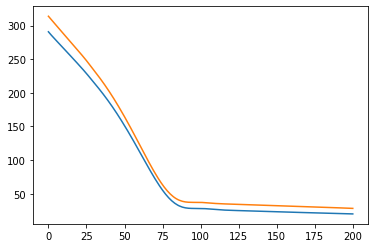

In [32]:
plt.plot(loss_trval_mod3_arr[:,1])
plt.plot(loss_trval_mod3_arr[:,2])
plt.show()

## Model 4: Median and standard deviation of grid and final race position

## Selecte input data for this model

In [33]:
xmod4_train=torch.from_numpy(np.float32(Xall_train[['MedianFinalPos','StdDevFinalPos','MedianStartPos','StdDevStartPos']].values))
xmod4_test=torch.from_numpy(np.float32(Xall_test[['MedianFinalPos','StdDevFinalPos','MedianStartPos','StdDevStartPos']].values))

### Define model architecture

In [34]:
## The architecture of models 3 and 4 is the same, it only changes the input data.

### Compile model and show summary

In [35]:
model4 = MLF1mod3()

In [36]:
optimMod4 = optim.Adam(model4.parameters(), lr=0.001)

### Train and evaluate model

In [37]:
loss_trval_mod4_arr=trainValModel(0,200,model4,optimMod4,loss_MLF1,xmod4_train,yTrain,xmod4_test,yTest)

Validation Loss: 2.968e+02
####Epoch 1 out of 200###
	---Training Loss: 2.733e+02,
	---Validation Loss: 2.968e+02
Validation Loss: 2.955e+02
####Epoch 2 out of 200###
	---Training Loss: 2.721e+02,
	---Validation Loss: 2.955e+02
Validation Loss: 2.942e+02
####Epoch 3 out of 200###
	---Training Loss: 2.708e+02,
	---Validation Loss: 2.942e+02
Validation Loss: 2.928e+02
####Epoch 4 out of 200###
	---Training Loss: 2.696e+02,
	---Validation Loss: 2.928e+02
Validation Loss: 2.914e+02
####Epoch 5 out of 200###
	---Training Loss: 2.683e+02,
	---Validation Loss: 2.914e+02
Validation Loss: 2.900e+02
####Epoch 6 out of 200###
	---Training Loss: 2.669e+02,
	---Validation Loss: 2.900e+02
Validation Loss: 2.886e+02
####Epoch 7 out of 200###
	---Training Loss: 2.655e+02,
	---Validation Loss: 2.886e+02
Validation Loss: 2.871e+02
####Epoch 8 out of 200###
	---Training Loss: 2.641e+02,
	---Validation Loss: 2.871e+02
Validation Loss: 2.855e+02
####Epoch 9 out of 200###
	---Training Loss: 2.627e+02,
	---V

Validation Loss: 2.693e+01
####Epoch 125 out of 200###
	---Training Loss: 1.994e+01,
	---Validation Loss: 2.693e+01
Validation Loss: 2.676e+01
####Epoch 126 out of 200###
	---Training Loss: 1.984e+01,
	---Validation Loss: 2.676e+01
Validation Loss: 2.658e+01
####Epoch 127 out of 200###
	---Training Loss: 1.974e+01,
	---Validation Loss: 2.658e+01
Validation Loss: 2.639e+01
####Epoch 128 out of 200###
	---Training Loss: 1.964e+01,
	---Validation Loss: 2.639e+01
Validation Loss: 2.619e+01
####Epoch 129 out of 200###
	---Training Loss: 1.954e+01,
	---Validation Loss: 2.619e+01
Validation Loss: 2.599e+01
####Epoch 130 out of 200###
	---Training Loss: 1.943e+01,
	---Validation Loss: 2.599e+01
Validation Loss: 2.579e+01
####Epoch 131 out of 200###
	---Training Loss: 1.932e+01,
	---Validation Loss: 2.579e+01
Validation Loss: 2.558e+01
####Epoch 132 out of 200###
	---Training Loss: 1.921e+01,
	---Validation Loss: 2.558e+01
Validation Loss: 2.538e+01
####Epoch 133 out of 200###
	---Training Loss

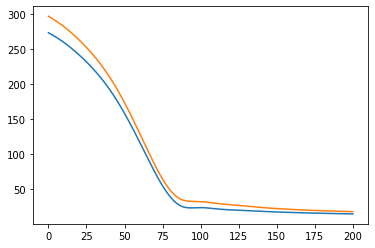

In [38]:
plt.plot(loss_trval_mod4_arr[:,1])
plt.plot(loss_trval_mod4_arr[:,2])
plt.show()

## Model 5: Mean and standard deviation of grid and final race position and number of entered races

## Selecte input data for this model

In [39]:
xmod5_train=torch.from_numpy(np.float32(Xall_train[['AvgFinalPos','StdDevFinalPos','AvgStartPos','StdDevStartPos','NumRaces']].values))
xmod5_test=torch.from_numpy(np.float32(Xall_test[['AvgFinalPos','StdDevFinalPos','AvgStartPos','StdDevStartPos','NumRaces']].values))

### Define model architecture

In [40]:
class MLF1mod5(nn.Module):
    def __init__(self):
        super().__init__()
        self.lay1 = nn.Linear(5,10)
        self.lay2 = nn.Linear(10,20)
        self.lay3 = nn.Linear(20,10)
        self.lay4  = nn.Linear(10,1)
        
    def forward(self, x):
        x = F.relu(self.lay1(x))
        x = F.relu(self.lay2(x))
        x = F.relu(self.lay3(x))
        x = self.lay4(x)
        return x

### Compile model and show summary

In [41]:
model5 = MLF1mod5()

In [42]:
optimMod5 = optim.Adam(model5.parameters(), lr=0.001)

### Train and evaluate model

In [43]:
loss_trval_mod5_arr=trainValModel(0,200,model5,optimMod5,loss_MLF1,xmod5_train,yTrain,xmod5_test,yTest)

Validation Loss: 3.296e+02
####Epoch 1 out of 200###
	---Training Loss: 3.052e+02,
	---Validation Loss: 3.296e+02
Validation Loss: 3.272e+02
####Epoch 2 out of 200###
	---Training Loss: 3.028e+02,
	---Validation Loss: 3.272e+02
Validation Loss: 3.248e+02
####Epoch 3 out of 200###
	---Training Loss: 3.005e+02,
	---Validation Loss: 3.248e+02
Validation Loss: 3.225e+02
####Epoch 4 out of 200###
	---Training Loss: 2.982e+02,
	---Validation Loss: 3.225e+02
Validation Loss: 3.202e+02
####Epoch 5 out of 200###
	---Training Loss: 2.960e+02,
	---Validation Loss: 3.202e+02
Validation Loss: 3.180e+02
####Epoch 6 out of 200###
	---Training Loss: 2.939e+02,
	---Validation Loss: 3.180e+02
Validation Loss: 3.159e+02
####Epoch 7 out of 200###
	---Training Loss: 2.918e+02,
	---Validation Loss: 3.159e+02
Validation Loss: 3.139e+02
####Epoch 8 out of 200###
	---Training Loss: 2.898e+02,
	---Validation Loss: 3.139e+02
Validation Loss: 3.121e+02
####Epoch 9 out of 200###
	---Training Loss: 2.879e+02,
	---V

Validation Loss: 6.177e+01
####Epoch 122 out of 200###
	---Training Loss: 5.128e+01,
	---Validation Loss: 6.177e+01
Validation Loss: 6.135e+01
####Epoch 123 out of 200###
	---Training Loss: 5.095e+01,
	---Validation Loss: 6.135e+01
Validation Loss: 6.093e+01
####Epoch 124 out of 200###
	---Training Loss: 5.061e+01,
	---Validation Loss: 6.093e+01
Validation Loss: 6.048e+01
####Epoch 125 out of 200###
	---Training Loss: 5.024e+01,
	---Validation Loss: 6.048e+01
Validation Loss: 6.002e+01
####Epoch 126 out of 200###
	---Training Loss: 4.986e+01,
	---Validation Loss: 6.002e+01
Validation Loss: 5.955e+01
####Epoch 127 out of 200###
	---Training Loss: 4.946e+01,
	---Validation Loss: 5.955e+01
Validation Loss: 5.908e+01
####Epoch 128 out of 200###
	---Training Loss: 4.904e+01,
	---Validation Loss: 5.908e+01
Validation Loss: 5.859e+01
####Epoch 129 out of 200###
	---Training Loss: 4.861e+01,
	---Validation Loss: 5.859e+01
Validation Loss: 5.810e+01
####Epoch 130 out of 200###
	---Training Loss

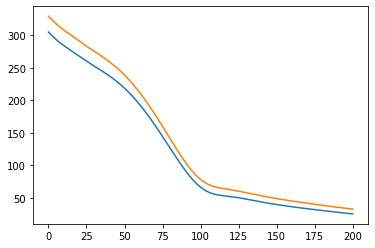

In [44]:
plt.plot(loss_trval_mod5_arr[:,1])
plt.plot(loss_trval_mod5_arr[:,2])
plt.show()

## Model 6: Mean and standard deviation of final race position and number of entered races

## Selecte input data for this model

In [45]:
xmod6_train=torch.from_numpy(np.float32(Xall_train[['AvgFinalPos','StdDevFinalPos','NumRaces']].values))
xmod6_test=torch.from_numpy(np.float32(Xall_test[['AvgFinalPos','StdDevFinalPos','NumRaces']].values))

### Define model architecture

In [46]:
class MLF1mod6(nn.Module):
    def __init__(self):
        super().__init__()
        self.lay1 = nn.Linear(3,10)
        self.lay2 = nn.Linear(10,20)
        self.lay3 = nn.Linear(20,10)
        self.lay4  = nn.Linear(10,1)
        
    def forward(self, x):
        x = F.relu(self.lay1(x))
        x = F.relu(self.lay2(x))
        x = F.relu(self.lay3(x))
        x = self.lay4(x)
        return x

### Compile model and show summary

In [47]:
model6 = MLF1mod6()

In [48]:
optimMod6 = optim.Adam(model6.parameters(), lr=0.001)

### Train and evaluate model

In [49]:
loss_trval_mod6_arr=trainValModel(0,200,model6,optimMod6,loss_MLF1,xmod6_train,yTrain,xmod6_test,yTest)

Validation Loss: 3.119e+02
####Epoch 1 out of 200###
	---Training Loss: 2.862e+02,
	---Validation Loss: 3.119e+02
Validation Loss: 3.110e+02
####Epoch 2 out of 200###
	---Training Loss: 2.854e+02,
	---Validation Loss: 3.110e+02
Validation Loss: 3.101e+02
####Epoch 3 out of 200###
	---Training Loss: 2.846e+02,
	---Validation Loss: 3.101e+02
Validation Loss: 3.092e+02
####Epoch 4 out of 200###
	---Training Loss: 2.838e+02,
	---Validation Loss: 3.092e+02
Validation Loss: 3.084e+02
####Epoch 5 out of 200###
	---Training Loss: 2.830e+02,
	---Validation Loss: 3.084e+02
Validation Loss: 3.075e+02
####Epoch 6 out of 200###
	---Training Loss: 2.822e+02,
	---Validation Loss: 3.075e+02
Validation Loss: 3.067e+02
####Epoch 7 out of 200###
	---Training Loss: 2.814e+02,
	---Validation Loss: 3.067e+02
Validation Loss: 3.058e+02
####Epoch 8 out of 200###
	---Training Loss: 2.807e+02,
	---Validation Loss: 3.058e+02
Validation Loss: 3.050e+02
####Epoch 9 out of 200###
	---Training Loss: 2.800e+02,
	---V

Validation Loss: 2.830e+01
####Epoch 128 out of 200###
	---Training Loss: 3.066e+01,
	---Validation Loss: 2.830e+01
Validation Loss: 2.808e+01
####Epoch 129 out of 200###
	---Training Loss: 3.023e+01,
	---Validation Loss: 2.808e+01
Validation Loss: 2.795e+01
####Epoch 130 out of 200###
	---Training Loss: 2.990e+01,
	---Validation Loss: 2.795e+01
Validation Loss: 2.787e+01
####Epoch 131 out of 200###
	---Training Loss: 2.965e+01,
	---Validation Loss: 2.787e+01
Validation Loss: 2.783e+01
####Epoch 132 out of 200###
	---Training Loss: 2.945e+01,
	---Validation Loss: 2.783e+01
Validation Loss: 2.780e+01
####Epoch 133 out of 200###
	---Training Loss: 2.928e+01,
	---Validation Loss: 2.780e+01
Validation Loss: 2.776e+01
####Epoch 134 out of 200###
	---Training Loss: 2.913e+01,
	---Validation Loss: 2.776e+01
Validation Loss: 2.770e+01
####Epoch 135 out of 200###
	---Training Loss: 2.897e+01,
	---Validation Loss: 2.770e+01
Validation Loss: 2.761e+01
####Epoch 136 out of 200###
	---Training Loss

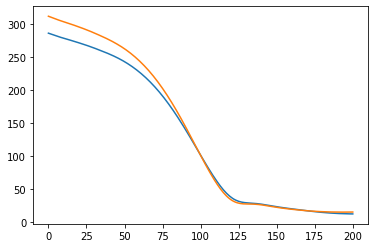

In [50]:
plt.plot(loss_trval_mod6_arr[:,1])
plt.plot(loss_trval_mod6_arr[:,2])
plt.show()

## Model 7: Shallow and wide - Mean and standard deviation of grid and final race position and number of entered races

## Selecte input data for this model

In [51]:
xmod7_train=torch.from_numpy(np.float32(Xall_train[['AvgFinalPos','StdDevFinalPos','AvgStartPos','StdDevStartPos','NumRaces']].values))
xmod7_test=torch.from_numpy(np.float32(Xall_test[['AvgFinalPos','StdDevFinalPos','AvgStartPos','StdDevStartPos','NumRaces']].values))

### Define model architecture

In [52]:
class MLF1mod7(nn.Module):
    def __init__(self):
        super().__init__()
        self.lay1 = nn.Linear(5,200)
        self.lay2 = nn.Linear(200,1)
        
    def forward(self, x):
        x = F.relu(self.lay1(x))
        x = self.lay2(x)
        return x

### Compile model and show summary

In [53]:
model7 = MLF1mod7()

In [54]:
optimMod7 = optim.Adam(model7.parameters(), lr=0.001)

### Train and evaluate model

In [55]:
loss_trval_mod7_arr=trainValModel(0,200,model7,optimMod7,loss_MLF1,xmod7_train,yTrain,xmod7_test,yTest)

Validation Loss: 4.665e+02
####Epoch 1 out of 200###
	---Training Loss: 4.671e+02,
	---Validation Loss: 4.665e+02
Validation Loss: 4.348e+02
####Epoch 2 out of 200###
	---Training Loss: 4.354e+02,
	---Validation Loss: 4.348e+02
Validation Loss: 4.044e+02
####Epoch 3 out of 200###
	---Training Loss: 4.050e+02,
	---Validation Loss: 4.044e+02
Validation Loss: 3.754e+02
####Epoch 4 out of 200###
	---Training Loss: 3.760e+02,
	---Validation Loss: 3.754e+02
Validation Loss: 3.478e+02
####Epoch 5 out of 200###
	---Training Loss: 3.484e+02,
	---Validation Loss: 3.478e+02
Validation Loss: 3.216e+02
####Epoch 6 out of 200###
	---Training Loss: 3.221e+02,
	---Validation Loss: 3.216e+02
Validation Loss: 2.968e+02
####Epoch 7 out of 200###
	---Training Loss: 2.971e+02,
	---Validation Loss: 2.968e+02
Validation Loss: 2.734e+02
####Epoch 8 out of 200###
	---Training Loss: 2.735e+02,
	---Validation Loss: 2.734e+02
Validation Loss: 2.513e+02
####Epoch 9 out of 200###
	---Training Loss: 2.512e+02,
	---V

Validation Loss: 1.124e+01
####Epoch 148 out of 200###
	---Training Loss: 7.990e+00,
	---Validation Loss: 1.124e+01
Validation Loss: 1.121e+01
####Epoch 149 out of 200###
	---Training Loss: 7.969e+00,
	---Validation Loss: 1.121e+01
Validation Loss: 1.119e+01
####Epoch 150 out of 200###
	---Training Loss: 7.950e+00,
	---Validation Loss: 1.119e+01
Validation Loss: 1.116e+01
####Epoch 151 out of 200###
	---Training Loss: 7.931e+00,
	---Validation Loss: 1.116e+01
Validation Loss: 1.114e+01
####Epoch 152 out of 200###
	---Training Loss: 7.913e+00,
	---Validation Loss: 1.114e+01
Validation Loss: 1.112e+01
####Epoch 153 out of 200###
	---Training Loss: 7.896e+00,
	---Validation Loss: 1.112e+01
Validation Loss: 1.110e+01
####Epoch 154 out of 200###
	---Training Loss: 7.879e+00,
	---Validation Loss: 1.110e+01
Validation Loss: 1.108e+01
####Epoch 155 out of 200###
	---Training Loss: 7.863e+00,
	---Validation Loss: 1.108e+01
Validation Loss: 1.107e+01
####Epoch 156 out of 200###
	---Training Loss

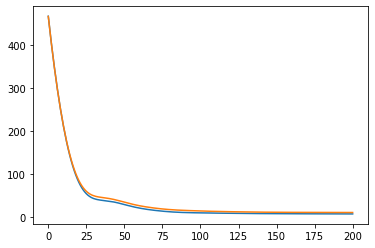

In [56]:
plt.plot(loss_trval_mod7_arr[:,1])
plt.plot(loss_trval_mod7_arr[:,2])
plt.show()

## Model 8: Deep and narrow - Mean and standard deviation of grid and final race position and number of entered races

## Selecte input data for this model

In [57]:
xmod8_train=torch.from_numpy(np.float32(Xall_train[['AvgFinalPos','StdDevFinalPos','AvgStartPos','StdDevStartPos','NumRaces']].values))
xmod8_test=torch.from_numpy(np.float32(Xall_test[['AvgFinalPos','StdDevFinalPos','AvgStartPos','StdDevStartPos','NumRaces']].values))

### Define model architecture

In [58]:
class MLF1mod8(nn.Module):
    def __init__(self):
        super().__init__()
        self.lay1 = nn.Linear(5,10)
        self.lay2 = nn.Linear(10,10)
        self.lay3 = nn.Linear(10,10)
        self.lay4 = nn.Linear(10,10)
        self.lay5 = nn.Linear(10,10)
        self.lay6 = nn.Linear(10,10)
        self.lay7 = nn.Linear(10,10)
        self.lay8 = nn.Linear(10,10)
        self.lay9 = nn.Linear(10,10)
        self.lay10 = nn.Linear(10,10)
        self.lay11 = nn.Linear(10,1)
        
    def forward(self, x):
        x = F.relu(self.lay1(x))
        x = F.relu(self.lay2(x))
        x = F.relu(self.lay3(x))
        x = F.relu(self.lay4(x))
        x = F.relu(self.lay5(x))
        x = F.relu(self.lay6(x))
        x = F.relu(self.lay7(x))
        x = F.relu(self.lay8(x))
        x = F.relu(self.lay9(x))
        x = F.relu(self.lay10(x))
        x = self.lay11(x)
        return x

### Compile model and show summary

In [59]:
model8 = MLF1mod8()

In [60]:
optimMod8 = optim.Adam(model8.parameters(), lr=0.001)

### Train and evaluate model

In [61]:
loss_trval_mod8_arr=trainValModel(0,200,model8,optimMod8,loss_MLF1,xmod8_train,yTrain,xmod8_test,yTest)

Validation Loss: 3.040e+02
####Epoch 1 out of 200###
	---Training Loss: 2.788e+02,
	---Validation Loss: 3.040e+02
Validation Loss: 3.039e+02
####Epoch 2 out of 200###
	---Training Loss: 2.787e+02,
	---Validation Loss: 3.039e+02
Validation Loss: 3.038e+02
####Epoch 3 out of 200###
	---Training Loss: 2.786e+02,
	---Validation Loss: 3.038e+02
Validation Loss: 3.037e+02
####Epoch 4 out of 200###
	---Training Loss: 2.786e+02,
	---Validation Loss: 3.037e+02
Validation Loss: 3.036e+02
####Epoch 5 out of 200###
	---Training Loss: 2.785e+02,
	---Validation Loss: 3.036e+02
Validation Loss: 3.035e+02
####Epoch 6 out of 200###
	---Training Loss: 2.784e+02,
	---Validation Loss: 3.035e+02
Validation Loss: 3.034e+02
####Epoch 7 out of 200###
	---Training Loss: 2.783e+02,
	---Validation Loss: 3.034e+02
Validation Loss: 3.033e+02
####Epoch 8 out of 200###
	---Training Loss: 2.782e+02,
	---Validation Loss: 3.033e+02
Validation Loss: 3.032e+02
####Epoch 9 out of 200###
	---Training Loss: 2.781e+02,
	---V

Validation Loss: 2.865e+02
####Epoch 105 out of 200###
	---Training Loss: 2.626e+02,
	---Validation Loss: 2.865e+02
Validation Loss: 2.862e+02
####Epoch 106 out of 200###
	---Training Loss: 2.623e+02,
	---Validation Loss: 2.862e+02
Validation Loss: 2.859e+02
####Epoch 107 out of 200###
	---Training Loss: 2.619e+02,
	---Validation Loss: 2.859e+02
Validation Loss: 2.855e+02
####Epoch 108 out of 200###
	---Training Loss: 2.616e+02,
	---Validation Loss: 2.855e+02
Validation Loss: 2.852e+02
####Epoch 109 out of 200###
	---Training Loss: 2.613e+02,
	---Validation Loss: 2.852e+02
Validation Loss: 2.848e+02
####Epoch 110 out of 200###
	---Training Loss: 2.610e+02,
	---Validation Loss: 2.848e+02
Validation Loss: 2.845e+02
####Epoch 111 out of 200###
	---Training Loss: 2.606e+02,
	---Validation Loss: 2.845e+02
Validation Loss: 2.841e+02
####Epoch 112 out of 200###
	---Training Loss: 2.603e+02,
	---Validation Loss: 2.841e+02
Validation Loss: 2.837e+02
####Epoch 113 out of 200###
	---Training Loss

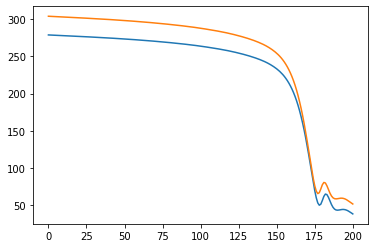

In [62]:
plt.plot(loss_trval_mod8_arr[:,1])
plt.plot(loss_trval_mod8_arr[:,2])
plt.show()